# Download PVPC prices for a time range with `aiopvpc`



In [1]:
from datetime import datetime

from aiopvpc.pvpc_data import PVPCData, REFERENCE_TZ

# Initialize PVPC handler
pvpc_handler = PVPCData(tariff="discrimination", zone_ceuta_melilla=False)

# download prices in range
start = datetime(2021, 5, 1, 22, tzinfo=REFERENCE_TZ)
end = datetime(2021, 6, 7, 16, tzinfo=REFERENCE_TZ)

prices_range: dict = await pvpc_handler.async_download_prices_for_range(start, end)

# show first values
list(prices_range.items())[:10]

Download of 883 prices from 2021-05-01 20:00:00+00:00 to 2021-06-07 14:00:00+00:00 in 0.16 sec


[(datetime.datetime(2021, 5, 1, 20, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.1708),
 (datetime.datetime(2021, 5, 1, 21, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.09135),
 (datetime.datetime(2021, 5, 1, 22, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.08392),
 (datetime.datetime(2021, 5, 1, 23, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.08088),
 (datetime.datetime(2021, 5, 2, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.0818),
 (datetime.datetime(2021, 5, 2, 1, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.08288),
 (datetime.datetime(2021, 5, 2, 2, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.08327),
 (datetime.datetime(2021, 5, 2, 3, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.08336),
 (datetime.datetime(2021, 5, 2, 4, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.08684),
 (datetime.datetime(2021, 5, 2, 5, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
  0.0833)]

## Plot PVPC prices with `pandas` and `matplotlib`

* Convert dict of downloaded prices to pd.Series
* Plot series as step graph with filled area

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd


# plot series as filled step graph
def plot_data(
    s_data: pd.Series,
    ylabel: str = "Consumo (kWh)",
    color = "xkcd:orangey red",
    figsize = (16, 7),
    tz = REFERENCE_TZ,
    fill_under: bool = True,
    title: str = None,
    plot_style: str = "seaborn-white",
    date_fmt: str = "%-d/%b\'%y",
    max_xticks: int = 10,
    ax = None,
):
    plt.style.use(plot_style)
    # Use local naive time index
    index_plot = s_data.index.tz_convert(str(tz)).tz_localize(None)
    ts0 = index_plot[0]
    tsf = index_plot[-1]

    # add 1 more point for final "step"
    delta_step = tsf - index_plot[-2]
    tsf += delta_step
    
    index_p = index_plot.tolist() + [tsf]
    values_p = s_data.values.tolist() + [s_data.values[-1]]

    # get figure params
    fig_p = {"ax": ax} if ax is not None else {"figure": plt.figure(figsize=figsize)}
    
    # plot values as step
    line, *_ = plt.step(
        index_p, values_p,
        where="post",
        lw=0.75, ls="-", alpha=.95, marker=None, color=color,
        label=ylabel,
        **fig_p,
    )

    # fill under line
    if fill_under:
        xy_line = line.get_xydata()
        plt.fill_between(
            xy_line[:, 0], xy_line[:, 1], color=color, step="post", alpha=.3
        )

    # style plot
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=(tsf - ts0).days // max_xticks + 1))
    ax.grid(True, which="both", axis="both")
    ax.set_xlim(ts0, tsf)
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_ylabel(ylabel, usetex=True)
    
    if title is not None:
        ax.set_title(title)
    
    return ax


2021-05-01 20:00:00+00:00    0.17080
2021-05-01 21:00:00+00:00    0.09135
2021-05-01 22:00:00+00:00    0.08392
2021-05-01 23:00:00+00:00    0.08088
2021-05-02 00:00:00+00:00    0.08180
                              ...   
2021-06-07 10:00:00+00:00    0.23198
2021-06-07 11:00:00+00:00    0.23150
2021-06-07 12:00:00+00:00    0.13706
2021-06-07 13:00:00+00:00    0.13554
2021-06-07 14:00:00+00:00    0.13540
Name: price_€_kWh, Length: 883, dtype: float64

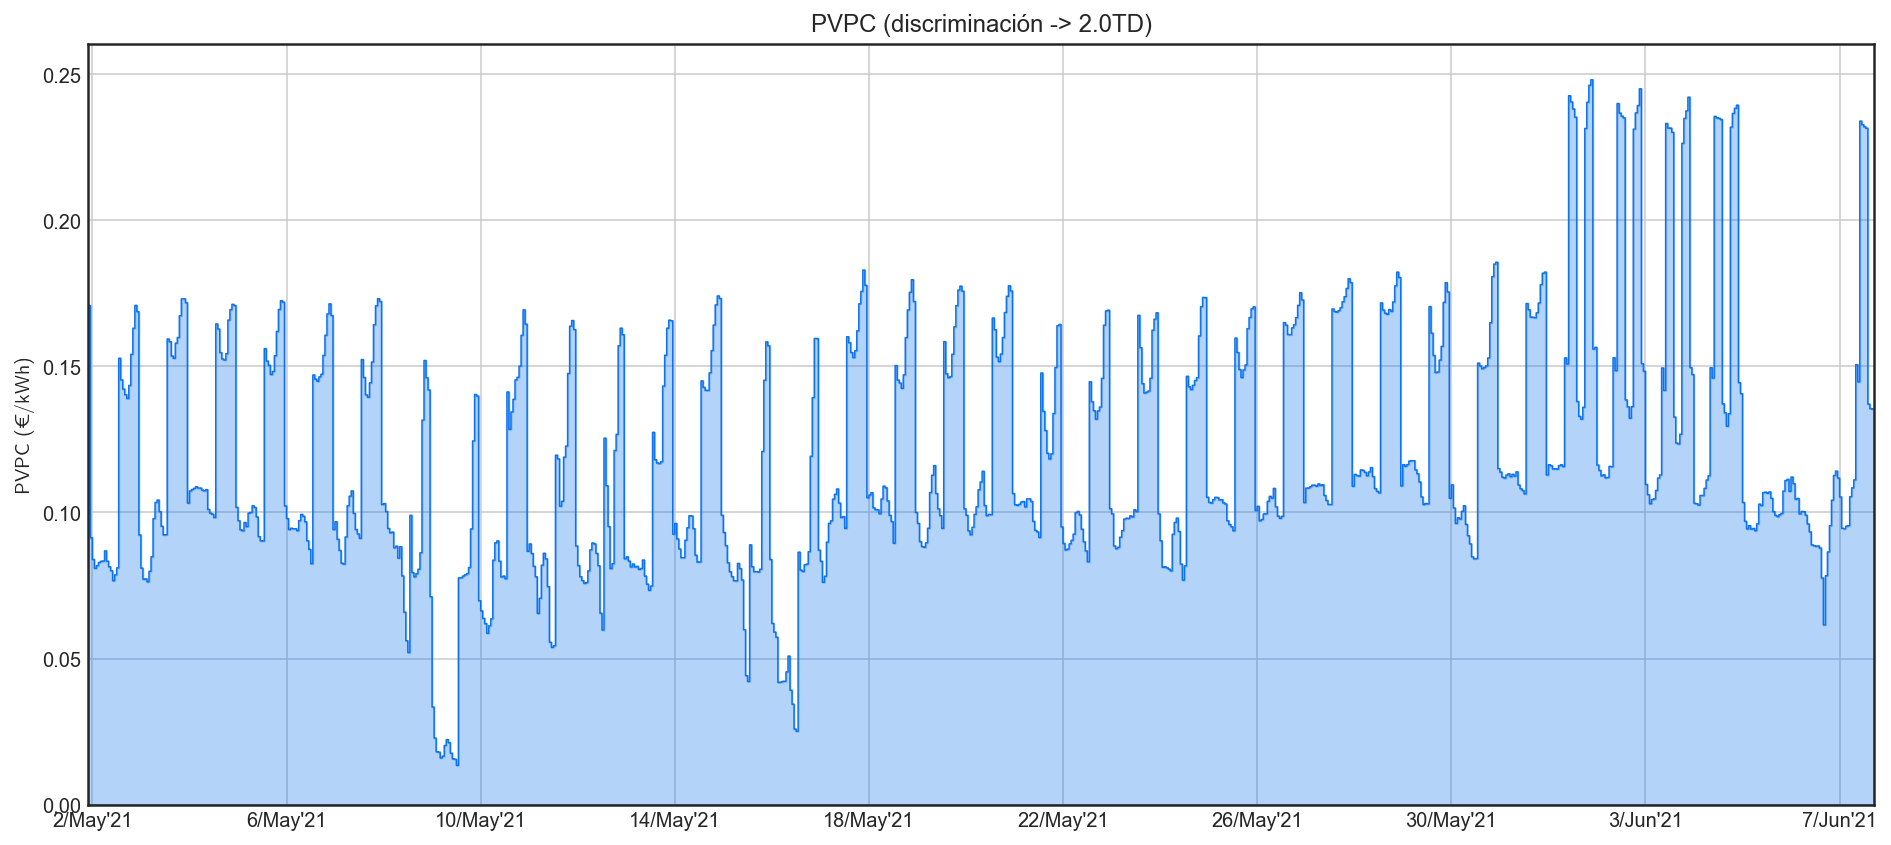

In [3]:
# move to pandas to plot series
s_price_example = pd.Series(prices_range, name="price_€_kWh")
display(s_price_example)

# plot prices
plot_data(
    s_price_example, "PVPC (€/kWh)", "xkcd:cerulean blue",
    figsize=(16, 7),
    tz=REFERENCE_TZ,
    fill_under=True,
    plot_style="seaborn-white",
    date_fmt="%-d/%b\'%y",
    max_xticks=10,
    title="PVPC (discriminación -> 2.0TD)",
)
plt.show()

### Download full PVPC detailed data in €/MWh

By not using a specific `tariff` in the `PVPCData` handler

In [4]:
full_pvpc_handler = PVPCData()

# download prices in range
start = datetime(2020, 3, 21)
end = datetime(2020, 4, 30, 18)

prices_data: dict = await full_pvpc_handler.async_download_prices_for_range(start, end)

# Example of detailed data
prices_data[min(prices_data)]

Download of 978 prices from 2020-03-20 23:00:00+00:00 to 2020-04-30 16:00:00+00:00 in 0.33 sec


{'GEN': 86.42,
 'NOC': 38.19,
 'VHC': 41.04,
 'COFGEN': 9.8155543e-05,
 'COFNOC': 0.000149140796,
 'COFVHC': 0.000144086677,
 'PMHGEN': 31.35,
 'PMHNOC': 29.97,
 'PMHVHC': 31.5,
 'SAHGEN': 3.51,
 'SAHNOC': 3.35,
 'SAHVHC': 3.53,
 'FOMGEN': 0.03,
 'FOMNOC': 0.03,
 'FOMVHC': 0.03,
 'FOSGEN': 0.17,
 'FOSNOC': 0.16,
 'FOSVHC': 0.17,
 'INTGEN': 0.04,
 'INTNOC': 0.04,
 'INTVHC': 0.04,
 'PCAPGEN': 5.68,
 'PCAPNOC': 0.94,
 'PCAPVHC': 1.34,
 'TEUGEN': 44.03,
 'TEUNOC': 2.22,
 'TEUVHC': 2.88,
 'CCVGEN': 1.61,
 'CCVNOC': 1.47,
 'CCVVHC': 1.55}

In [5]:
# Move to pandas
df_pvpc = pd.DataFrame(prices_data).T
df_pvpc

,GEN,NOC,VHC,COFGEN,COFNOC,COFVHC,PMHGEN,PMHNOC,PMHVHC,SAHGEN,...,INTVHC,PCAPGEN,PCAPNOC,PCAPVHC,TEUGEN,TEUNOC,TEUVHC,CCVGEN,CCVNOC,CCVVHC
2020-03-20 23:00:00+00:00,86.42,38.19,41.04,0.000098,0.000149,0.000144,31.35,29.97,31.50,3.51,...,0.04,5.68,0.94,1.34,44.03,2.22,2.88,1.61,1.47,1.55
2020-03-21 00:00:00+00:00,83.73,35.57,33.06,0.000079,0.000132,0.000162,28.04,26.79,25.99,4.13,...,0.03,5.71,0.95,0.74,44.03,2.22,0.89,1.58,1.44,1.39
2020-03-21 01:00:00+00:00,87.26,38.90,36.27,0.000068,0.000120,0.000159,31.61,30.18,29.26,4.01,...,0.03,5.74,0.95,0.74,44.03,2.22,0.89,1.64,1.49,1.45
2020-03-21 02:00:00+00:00,87.93,39.50,36.82,0.000062,0.000112,0.000152,31.67,30.22,29.27,4.60,...,0.03,5.75,0.95,0.74,44.03,2.22,0.89,1.65,1.50,1.45
2020-03-21 03:00:00+00:00,88.53,40.07,37.40,0.000060,0.000110,0.000145,32.29,30.81,29.87,4.56,...,0.03,5.75,0.95,0.74,44.03,2.22,0.89,1.66,1.51,1.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30 12:00:00+00:00,60.75,79.01,79.01,0.000125,0.000085,0.000072,6.35,6.39,6.39,3.63,...,0.05,5.33,5.53,5.53,44.03,62.01,62.01,1.18,1.19,1.19
2020-04-30 13:00:00+00:00,61.16,79.44,79.44,0.000116,0.000078,0.000068,6.41,6.46,6.46,3.95,...,0.05,5.36,5.56,5.56,44.03,62.01,62.01,1.18,1.20,1.20
2020-04-30 14:00:00+00:00,61.14,79.43,79.43,0.000111,0.000074,0.000066,6.40,6.45,6.45,3.95,...,0.05,5.35,5.55,5.55,44.03,62.01,62.01,1.18,1.19,1.19
2020-04-30 15:00:00+00:00,61.28,79.56,79.56,0.000111,0.000074,0.000066,6.46,6.51,6.51,4.04,...,0.05,5.34,5.54,5.54,44.03,62.01,62.01,1.18,1.20,1.20


,NOC,PMHNOC,SAHNOC,FOMNOC,FOSNOC,INTNOC,PCAPNOC,TEUNOC,CCVNOC
2020-03-20 23:00:00+00:00,38.19,29.97,3.35,0.03,0.16,0.04,0.94,2.22,1.47
2020-03-21 00:00:00+00:00,35.57,26.79,3.95,0.03,0.16,0.04,0.95,2.22,1.44
2020-03-21 01:00:00+00:00,38.90,30.18,3.83,0.03,0.16,0.04,0.95,2.22,1.49
2020-03-21 02:00:00+00:00,39.50,30.22,4.38,0.03,0.16,0.04,0.95,2.22,1.50
2020-03-21 03:00:00+00:00,40.07,30.81,4.35,0.03,0.16,0.04,0.95,2.22,1.51
...,...,...,...,...,...,...,...,...,...
2020-03-24 18:00:00+00:00,110.67,39.12,2.14,0.03,0.16,0.03,5.52,62.01,1.65
2020-03-24 19:00:00+00:00,111.02,39.71,1.84,0.03,0.16,0.03,5.56,62.01,1.66
2020-03-24 20:00:00+00:00,110.88,39.35,2.04,0.03,0.16,0.04,5.59,62.01,1.67
2020-03-24 21:00:00+00:00,42.79,35.55,2.36,0.03,0.16,0.03,0.92,2.22,1.52


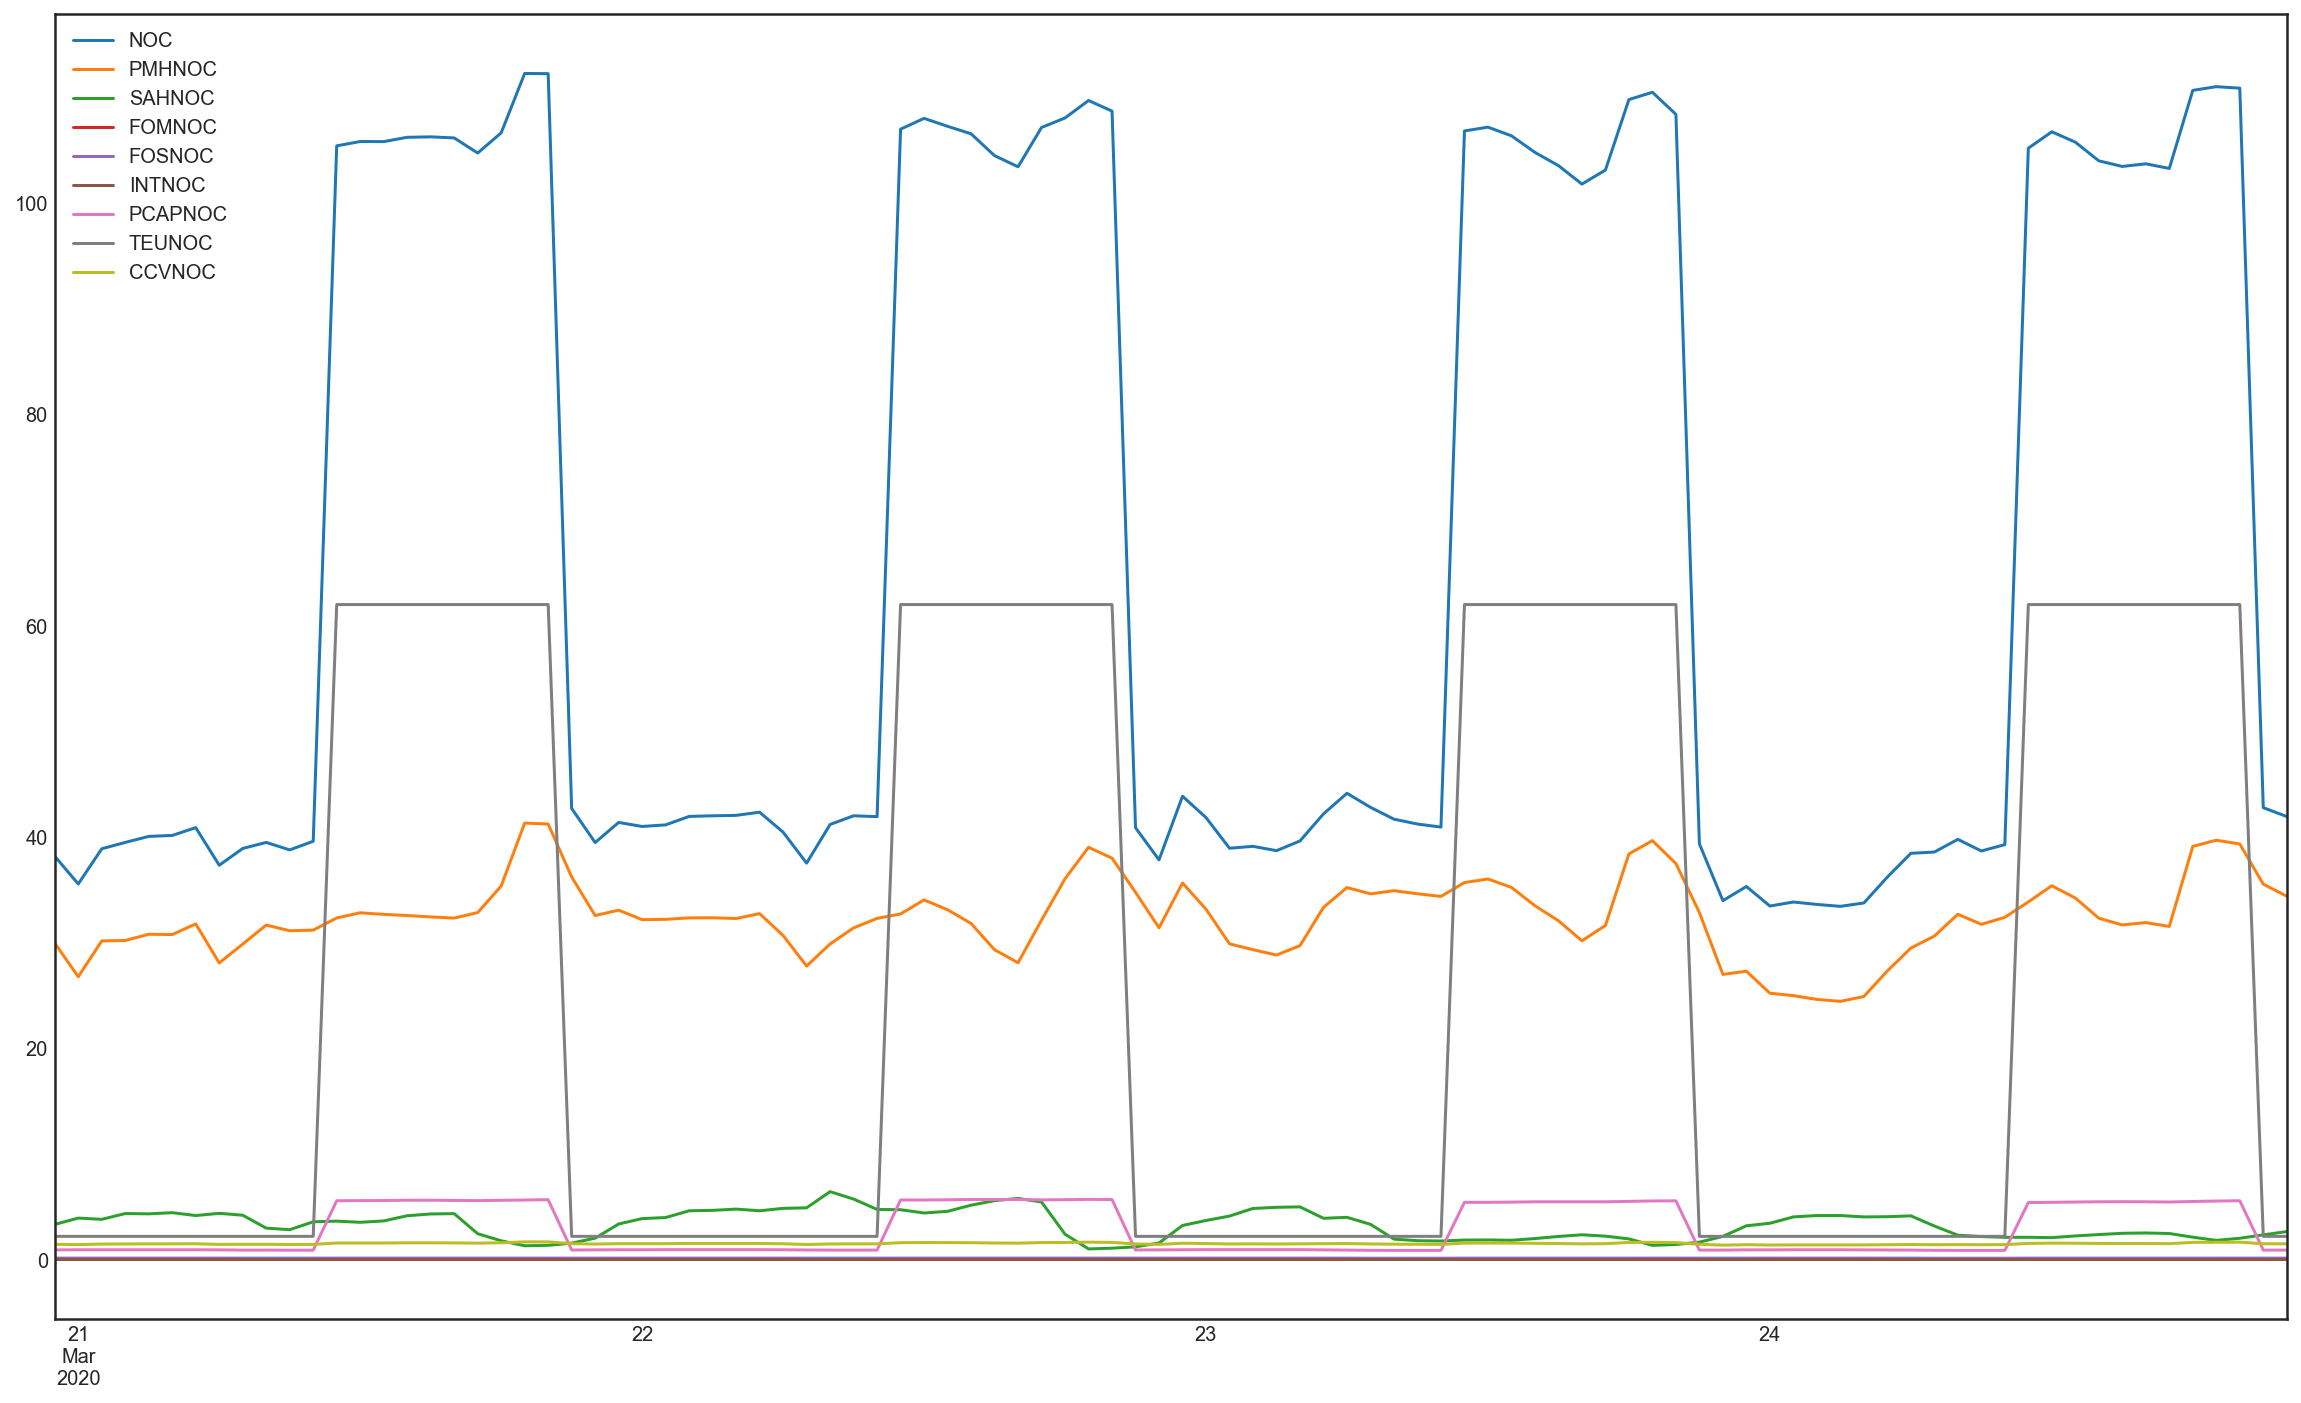

In [6]:
# show some details
subset_noc = df_pvpc.iloc[:96].T[df_pvpc.columns.str.endswith("NOC")].drop("COFNOC").T
display(subset_noc)

subset_noc.plot(figsize=(20, 12));

In [7]:
# download prices in range
start = datetime(2021, 6, 1)
end = datetime(2021, 6, 7)

prices_data: dict = await full_pvpc_handler.async_download_prices_for_range(start, end)

# Example of detailed data
prices_data[min(prices_data)]

Download of 145 prices from 2021-05-31 22:00:00+00:00 to 2021-06-06 22:00:00+00:00 in 1.21 sec


{'PCB': 116.33,
 'CYM': 116.33,
 'COF2TD': 8.8075182e-05,
 'PMHPCB': 104.0,
 'PMHCYM': 104.0,
 'SAHPCB': 3.56,
 'SAHCYM': 3.56,
 'FOMPCB': 0.03,
 'FOMCYM': 0.03,
 'FOSPCB': 0.17,
 'FOSCYM': 0.17,
 'INTPCB': 0.0,
 'INTCYM': 0.0,
 'PCAPPCB': 0.0,
 'PCAPCYM': 0.0,
 'TEUPCB': 6.0,
 'TEUCYM': 6.0,
 'CCVPCB': 2.57,
 'CCVCYM': 2.57,
 'EDSRPCB': 0.0,
 'EDSRCYM': 0.0}

,PCB,PMHPCB,SAHPCB,FOMPCB,FOSPCB,INTPCB,PCAPPCB,TEUPCB,CCVPCB,EDSRPCB
2021-05-31 22:00:00+00:00,116.33,104.00,3.56,0.03,0.17,0.0,0.00,6.00,2.57,0.0
2021-05-31 23:00:00+00:00,115.95,103.18,3.99,0.03,0.17,0.0,0.00,6.00,2.58,0.0
2021-06-01 00:00:00+00:00,114.89,101.87,4.25,0.03,0.17,0.0,0.00,6.00,2.56,0.0
2021-06-01 01:00:00+00:00,114.96,102.01,4.19,0.03,0.17,0.0,0.00,6.00,2.57,0.0
2021-06-01 02:00:00+00:00,114.84,101.87,4.21,0.03,0.17,0.0,0.00,6.00,2.56,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-04 17:00:00+00:00,236.58,93.83,4.93,0.03,0.17,0.0,2.04,133.12,2.46,0.0
2021-06-04 18:00:00+00:00,238.32,94.46,5.99,0.03,0.17,0.0,2.06,133.12,2.49,0.0
2021-06-04 19:00:00+00:00,239.39,96.53,4.96,0.03,0.17,0.0,2.07,133.12,2.51,0.0
2021-06-04 20:00:00+00:00,144.42,94.32,5.31,0.03,0.17,0.0,0.35,41.77,2.47,0.0


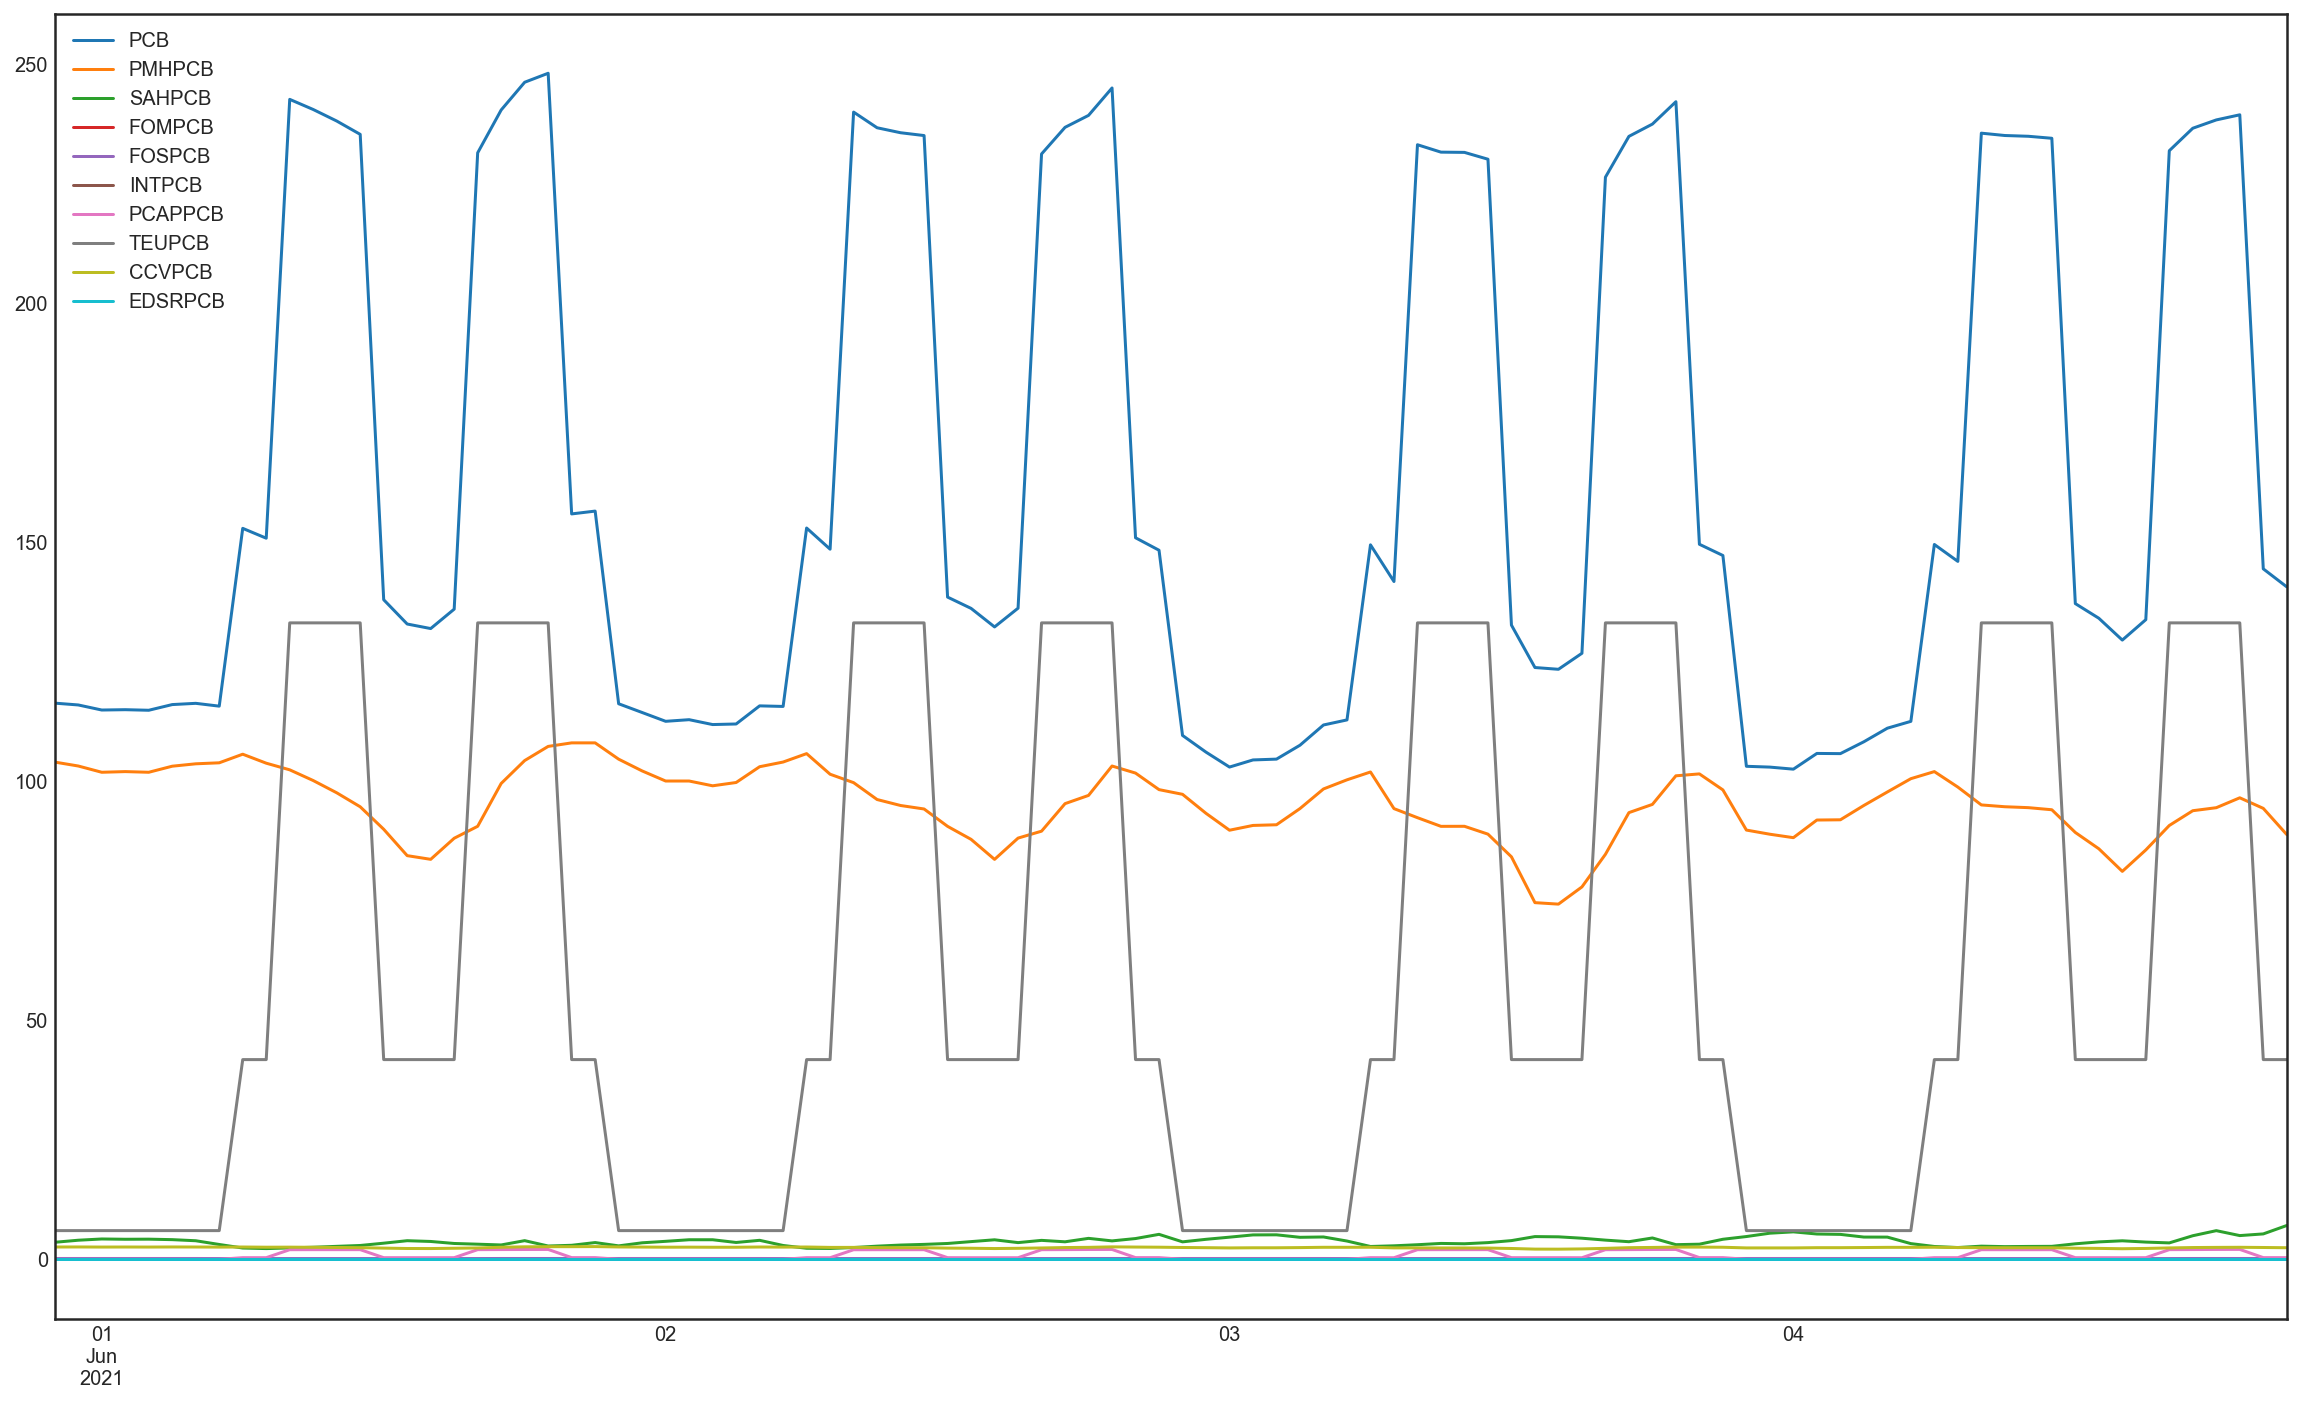

In [8]:
# show some details
df_pvpc = pd.DataFrame(prices_data).T
subset_noc = df_pvpc.iloc[:96].T[df_pvpc.columns.str.endswith("PCB")].T
display(subset_noc)

subset_noc.plot(figsize=(20, 12));